# Face De-Blurring Deep Learning Model

## Importing Necessary Packages

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Conv2DTranspose, Flatten, Reshape, Input, BatchNormalization, Activation
from tensorflow.keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
import keras.backend as K

import pickle
import joblib

2024-04-03 17:00:59.690122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 17:00:59.690219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 17:00:59.818754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading Images

In [2]:
subsets = ['CelebA', 'Gopro', 'HIDE', 'Helen', 'RealBlur_J', 'RealBlur_R', 'TextOCR', 'Wider-Face']
print(subsets)

['CelebA', 'Gopro', 'HIDE', 'Helen', 'RealBlur_J', 'RealBlur_R', 'TextOCR', 'Wider-Face']


In [3]:
train_frames_path = '/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/' + subsets[0] + '/train/'
val_frames_path = '/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/' + subsets[0] + '/validation/'
test_frames_path = '/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/' + subsets[0] + '/test/'

print(train_frames_path)
print(val_frames_path)
print(test_frames_path)

/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/CelebA/train/
/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/CelebA/validation/
/kaggle/input/a-curated-list-of-image-deblurring-datasets/DBlur/CelebA/test/


In [4]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (64, 64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.0
    img = np.reshape(img, (64, 64, 3))
    return img

In [5]:
# Training set
train_blurred_frames = os.listdir(train_frames_path + 'blur/')[:5000]
train_sharp_frames = os.listdir(train_frames_path + 'sharp/')[:5000]

# validation set
val_blurred_frames = os.listdir(val_frames_path + 'blur/')[:1000]
val_sharp_frames = os.listdir(val_frames_path + 'sharp/')[:1000]

# Testing set
test_blurred_frames = os.listdir(test_frames_path + 'blur/')[:1000]
test_sharp_frames = os.listdir(test_frames_path + 'sharp/')[:1000]

In [6]:
# Training set
train_blurred_frames = [process_image(train_frames_path + 'blur/' + file) for file in train_blurred_frames]
train_sharp_frames = [process_image(train_frames_path + 'sharp/' + file) for file in train_sharp_frames]

# validation set
val_blurred_frames = [process_image(val_frames_path + 'blur/' + file) for file in val_blurred_frames]
val_sharp_frames = [process_image(val_frames_path + 'sharp/' + file) for file in val_sharp_frames]

# Testing set
test_blurred_frames = [process_image(test_frames_path + 'blur/' + file) for file in test_blurred_frames]
test_sharp_frames = [process_image(test_frames_path + 'sharp/' + file) for file in test_sharp_frames]

In [7]:
# Training set
print(len(train_blurred_frames))
print(len(train_sharp_frames))

# validation set
print(len(val_blurred_frames))
print(len(val_sharp_frames))

# Testing set
print(len(test_blurred_frames))
print(len(test_sharp_frames))

5000
5000
1000
1000
1000
1000


In [8]:
# Training set
train_blurred_frames = np.asarray(train_blurred_frames)
train_sharp_frames = np.asarray(train_sharp_frames)

# validation set
val_blurred_frames = np.asarray(val_blurred_frames)
val_sharp_frames = np.asarray(val_sharp_frames)

# Testing set
test_blurred_frames = np.asarray(test_blurred_frames)
test_sharp_frames = np.asarray(test_sharp_frames)

In [9]:
print('Training set:', train_blurred_frames.shape, train_sharp_frames.shape)
print('Validation set:', val_blurred_frames.shape, val_sharp_frames.shape)
print('Testing set:', test_blurred_frames.shape, test_sharp_frames.shape)

Training set: (5000, 64, 64, 3) (5000, 64, 64, 3)
Validation set: (1000, 64, 64, 3) (1000, 64, 64, 3)
Testing set: (1000, 64, 64, 3) (1000, 64, 64, 3)


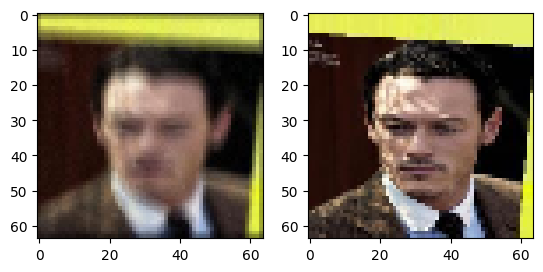

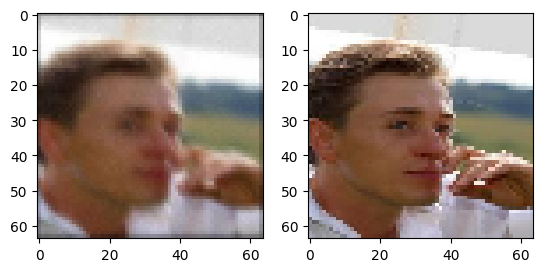

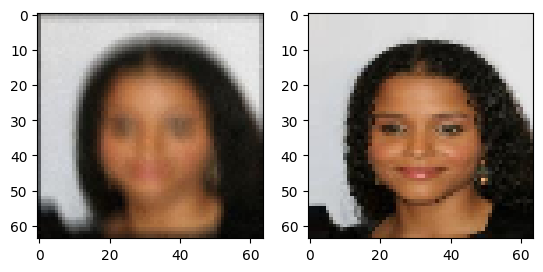

In [10]:
for cnt in range(3):   
    index = random.randint(0, len(train_blurred_frames)-1)

    image_blur = train_blurred_frames[index]
    image_sharp = train_sharp_frames[index]

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(image_blur)

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(image_sharp)

## Defining CNN Model

### CNN Model - 1

In [11]:
deblur_CNN_input = Input(shape=(64,64,3))

# HIDDEN LAYERS
deblur_CNN_layer1 = Conv2D(filters=128, kernel_size=10, strides=1, padding='same')(deblur_CNN_input)
deblur_CNN_layer1 = BatchNormalization()(deblur_CNN_layer1)
deblur_CNN_layer1 = Activation('relu')(deblur_CNN_layer1)

deblur_CNN_layer2 = Conv2D(filters=320, kernel_size=1, strides=1, padding='same')(deblur_CNN_layer1)
deblur_CNN_layer2 = BatchNormalization()(deblur_CNN_layer2)
deblur_CNN_layer2 = Activation('relu')(deblur_CNN_layer2)

deblur_CNN_layer3 = Conv2D(filters=320, kernel_size=1, strides=1, padding='same')(deblur_CNN_layer2)
deblur_CNN_layer1 = BatchNormalization()(deblur_CNN_layer3)
deblur_CNN_layer1 = Activation('relu')(deblur_CNN_layer3)

deblur_CNN_layer4 = Conv2D(filters=320, kernel_size=1, strides=1, padding='same')(deblur_CNN_layer3)
deblur_CNN_layer4 = BatchNormalization()(deblur_CNN_layer4)
deblur_CNN_layer4 = Activation('relu')(deblur_CNN_layer4)

deblur_CNN_layer5 = Conv2D(filters=128, kernel_size=1, strides=1, padding='same')(deblur_CNN_layer4)
deblur_CNN_layer5 = BatchNormalization()(deblur_CNN_layer5)
deblur_CNN_layer5 = Activation('relu')(deblur_CNN_layer5)

deblur_CNN_layer6 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(deblur_CNN_layer5)
deblur_CNN_layer6 = BatchNormalization()(deblur_CNN_layer6)
deblur_CNN_layer6 = Activation('relu')(deblur_CNN_layer6)

deblur_CNN_layer7 = Conv2D(filters=512, kernel_size=1, strides=1, padding='same')(deblur_CNN_layer6)
deblur_CNN_layer7 = BatchNormalization()(deblur_CNN_layer7)
deblur_CNN_layer7 = Activation('relu')(deblur_CNN_layer7)

deblur_CNN_layer8 = Conv2D(filters=128, kernel_size=5, strides=1, padding='same')(deblur_CNN_layer7)
deblur_CNN_layer8 = BatchNormalization()(deblur_CNN_layer8)
deblur_CNN_layer8 = Activation('relu')(deblur_CNN_layer8)

deblur_CNN_layer9 = Conv2D(filters=128, kernel_size=5, strides=1, padding='same')(deblur_CNN_layer8)
deblur_CNN_layer9 = BatchNormalization()(deblur_CNN_layer9)
deblur_CNN_layer9 = Activation('relu')(deblur_CNN_layer9)

deblur_CNN_layer10 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(deblur_CNN_layer9)
deblur_CNN_layer10 = BatchNormalization()(deblur_CNN_layer10)
deblur_CNN_layer10 = Activation('relu')(deblur_CNN_layer10)

deblur_CNN_layer11 = Conv2D(filters=128, kernel_size=5, strides=1, padding='same')(deblur_CNN_layer10)
deblur_CNN_layer11 = BatchNormalization()(deblur_CNN_layer11)
deblur_CNN_layer11 = Activation('relu')(deblur_CNN_layer11)

deblur_CNN_layer12 = Conv2D(filters=128, kernel_size=5, strides=1, padding='same')(deblur_CNN_layer11)
deblur_CNN_layer12 = BatchNormalization()(deblur_CNN_layer12)
deblur_CNN_layer12 = Activation('relu')(deblur_CNN_layer12)

deblur_CNN_layer13 = Conv2D(filters=256, kernel_size=1, strides=1, padding='same')(deblur_CNN_layer12)
deblur_CNN_layer13 = BatchNormalization()(deblur_CNN_layer13)
deblur_CNN_layer13 = Activation('relu')(deblur_CNN_layer13)

deblur_CNN_layer14 = Conv2D(filters=64, kernel_size=7, strides=1, padding='same')(deblur_CNN_layer13)
deblur_CNN_layer14 = BatchNormalization()(deblur_CNN_layer14)
deblur_CNN_layer14 = Activation('relu')(deblur_CNN_layer14)

deblur_CNN_output = Conv2D(filters=3, kernel_size=7, strides=1, padding='same', activation='relu')(deblur_CNN_layer14)

deblur_CNN = Model(inputs=deblur_CNN_input, outputs=deblur_CNN_output)

In [12]:
deblur_CNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [13]:
deblur_CNN.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 128)    │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 320)    │        41,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 320)    │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 320)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 320)    │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 320)    │       102,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 320)    │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 320)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 512)    │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           51

 Total params: 4,410,563 (16.82 MB)

 Trainable params: 4,405,571 (16.81 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [14]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), 
                               cooldown=0, 
                               patience=5, 
                               verbose=1, 
                               min_lr=0.5e-6)

ES = EarlyStopping(patience=5, 
                   mode='min', 
                   monitor='val_loss', 
                   restore_best_weights=True)

In [15]:
history = deblur_CNN.fit(train_blurred_frames, 
                         train_sharp_frames, 
                         epochs=20, 
                         batch_size=32, 
                         validation_data=(val_blurred_frames, val_sharp_frames), 
                         callbacks=[lr_reducer, ES])

Epoch 1/20


I0000 00:00:1712163799.376746      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 120s 446ms/step - accuracy: 0.6622 - loss: 0.1466 - val_accuracy: 0.1700 - val_loss: 0.0986 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 330ms/step - accuracy: 0.7318 - loss: 0.0864 - val_accuracy: 0.3455 - val_loss: 0.0889 - learning_rate: 0.0010
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 330ms/step - accuracy: 0.7311 - loss: 0.0867 - val_accuracy: 0.6947 - val_loss: 0.0831 - learning_rate: 0.0010
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 329ms/step - accuracy: 0.7403 - loss: 0.0851 - val_accuracy: 0.2849 - val_loss: 0.1145 - learning_rate: 0.0010
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 329ms/step - accuracy: 0.7386 - loss: 0.0842 - val_accuracy: 0.7355 - val_loss: 0.0850 - learning_rate: 0.0010
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 329ms/step - accuracy: 0.7496 - loss: 0.0825 - val_accuracy: 0.6860 - val_loss: 0.0836 - learning_rate: 0.0010
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 330ms/step - accuracy: 0.7410 - loss

In [16]:
loss, accuracy = deblur_CNN.evaluate(test_blurred_frames, test_sharp_frames)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7714 - loss: 0.0831
Test Loss: 0.08118269592523575
Test Accuracy: 0.7754396796226501


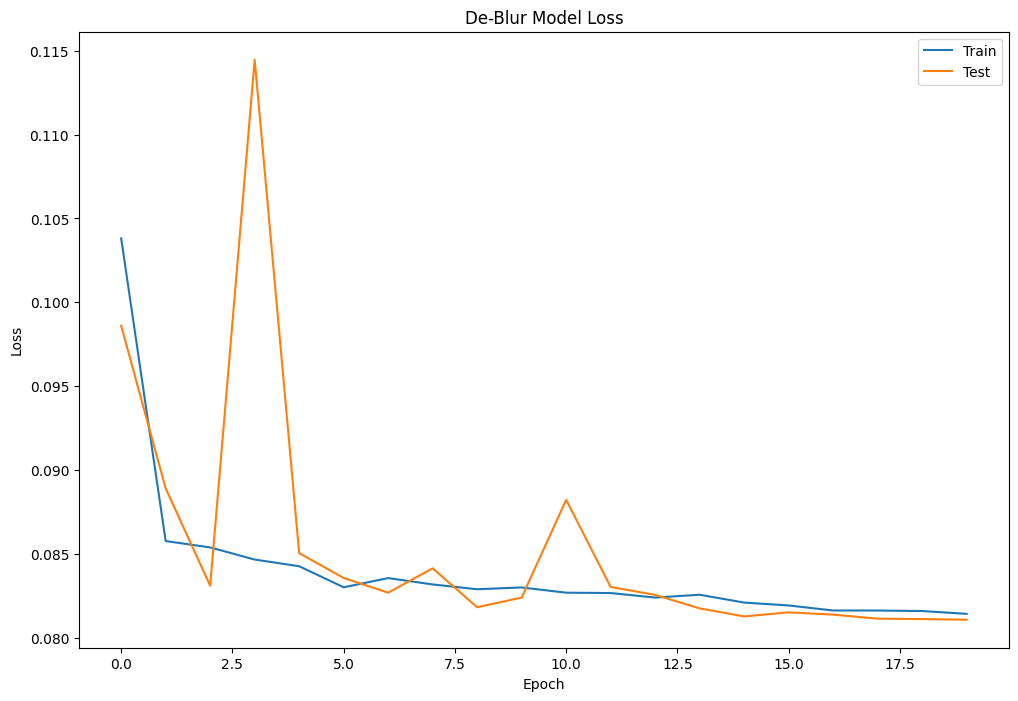

In [17]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('De-Blur Model Loss')
plt.savefig('De-Blur-Model-Loss.png')
plt.show()

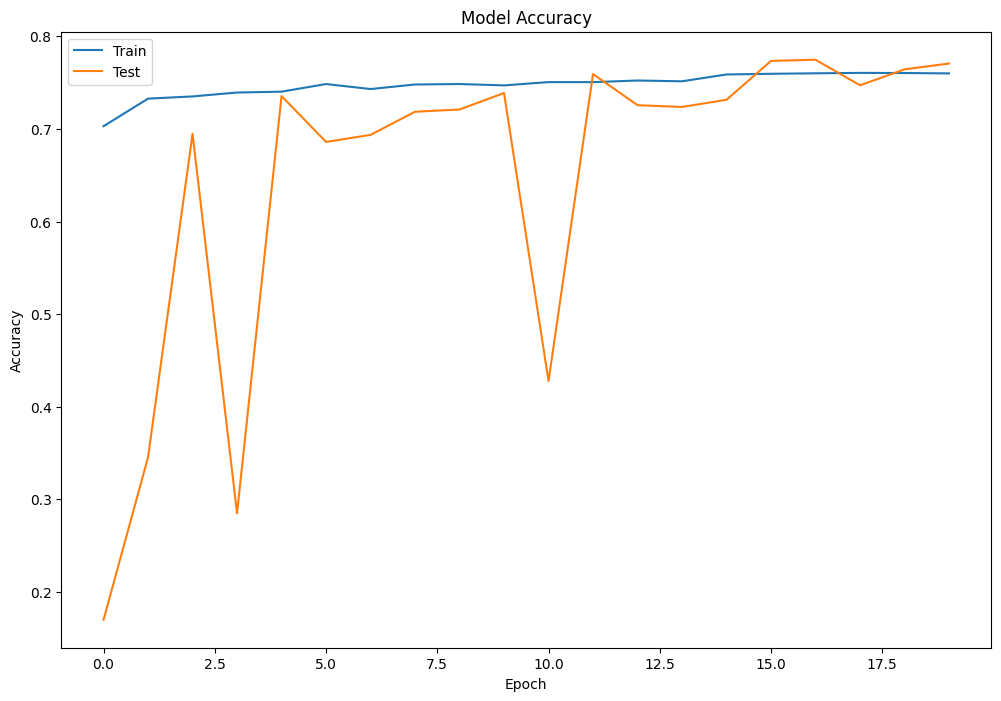

In [18]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.savefig('De-Blur-Model-Accuracy.png')
plt.show()

### De Blurred Faces


			Input						Ground Truth						Predicted Value


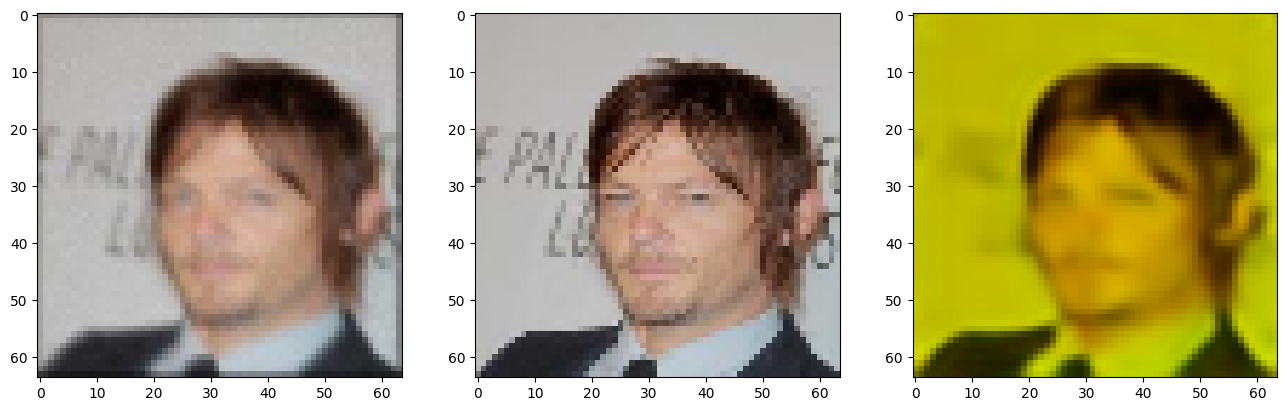

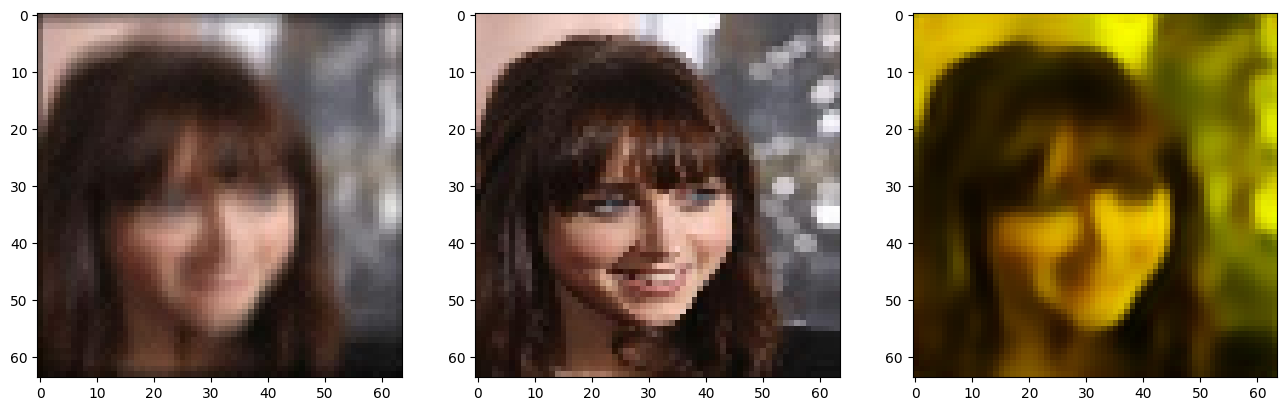

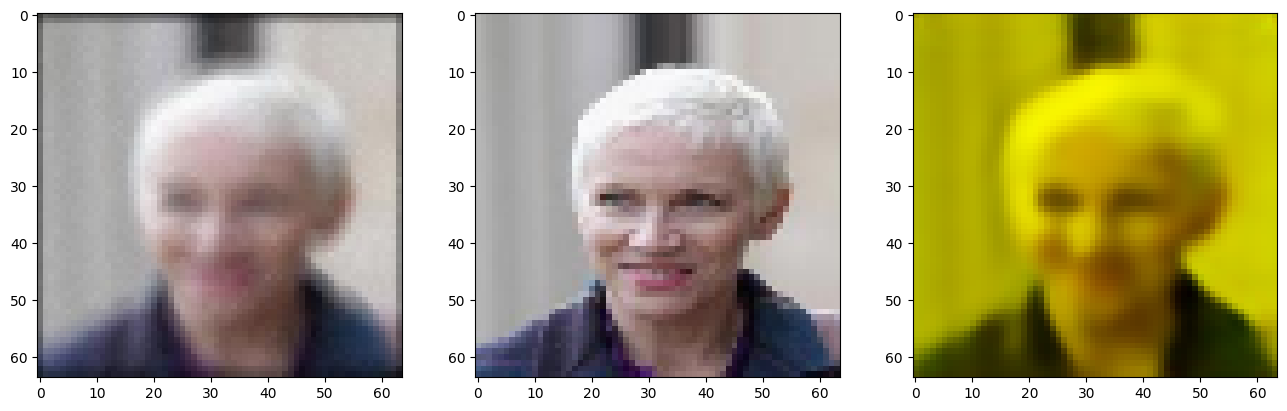

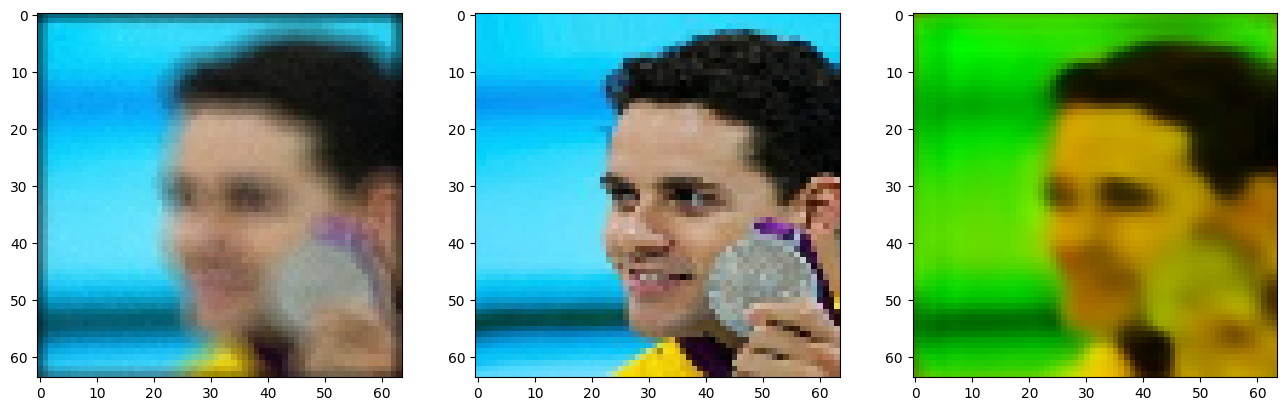

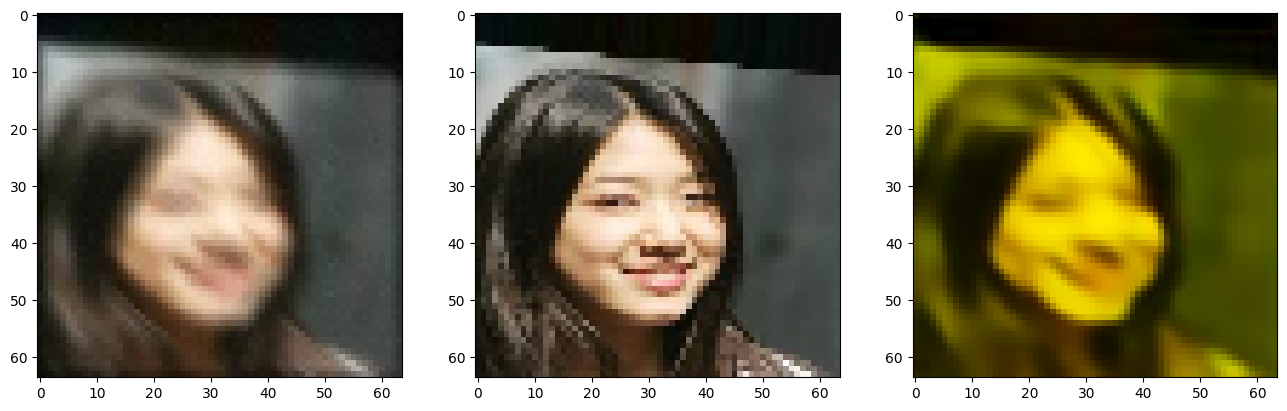

In [49]:
print("\n\t\t\tInput\t\t\t\t\t\tGround Truth\t\t\t\t\t\tPredicted Value")

for i in range(5):
    index = random.randint(0, len(test_blurred_frames)-1)

    x = test_blurred_frames[index]
    y = test_sharp_frames[index]

    x_inp = x.reshape(1,64,64,3)
    result = deblur_CNN.predict(x_inp, verbose = 0)
    result = result.reshape(64,64,3)

    fig = plt.figure(figsize=(16,13))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    
    fig.savefig('deblur_result.png')
    plt.imshow(result)

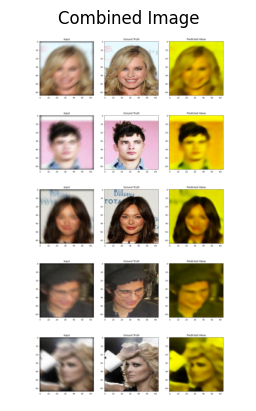

Combined image saved successfully: deblur_result.png


In [53]:
subplot_paths = []

for i in range(5):
    index = random.randint(0, len(test_blurred_frames) - 1)

    x = test_blurred_frames[index]
    y = test_sharp_frames[index]

    x_inp = x.reshape(1, 64, 64, 3)
    result = deblur_CNN.predict(x_inp, verbose=0)
    result = result.reshape(64, 64, 3)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    axes[0].imshow(x)
    axes[0].set_title("Input")

    axes[1].imshow(y)
    axes[1].set_title("Ground Truth")

    axes[2].imshow(result)
    axes[2].set_title("Predicted Value")

    subplot_path = f"subplot_{i + 1}.png"
    plt.savefig(subplot_path)
    plt.close(fig)

    subplot_paths.append(subplot_path)

combined_image = np.concatenate([plt.imread(path) for path in subplot_paths], axis=0)

output_image_path = "deblur_result.png"
plt.imsave(output_image_path, combined_image)

plt.imshow(combined_image)
plt.axis('off')
plt.title("Combined Image")
plt.show()

print("Combined image saved successfully:", output_image_path)

In [20]:
model_json = deblur_CNN.to_json()
with open("deblur_CNN_architecture.json", "w") as json_file:
    json_file.write(model_json)

deblur_CNN.save_weights("deblur_CNN.weights.h5")

In [41]:
tf.saved_model.save(deblur_CNN, 'deblur_CNN_model')

In [42]:
deblur_CNN.save('deblur_CNN_model.keras')

### CNN Model - 2

In [23]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print('Device:', tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [24]:
with strategy.scope():
    i = Input(shape=(64,64,3))

    x = Conv2D(64, (3,3), strides = 2, activation='relu',padding='same')(i)

    x = Conv2D(128, (3,3), strides = 2, activation='relu',padding='same')(x)

    x = Conv2D(256, (3,3), strides = 2, activation='relu',padding='same')(x)
    
    shape = x.shape
        
    encoder_model = Model(i, x, name = 'encoder_model')
    encoder_model.summary()

Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 370,816 (1.41 MB)

 Trainable params: 370,816 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
with strategy.scope():
    latent_inputs = Input(shape=shape[1:], name='decoder_input')

    x = Conv2DTranspose(256, (3,3),activation='relu', strides=2, padding='same')(latent_inputs)
    x = Conv2DTranspose(128, (3,3),activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(64, (3,3),activation='relu', strides=2, padding='same')(x)

    x = Conv2D(3, (3,3),activation='sigmoid', padding='same', name = 'decoder_output')(x)
    
    decoder_model = Model(latent_inputs, x, name = 'decoder_model')
    decoder_model.summary()

Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 960,643 (3.66 MB)

 Trainable params: 960,643 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
with strategy.scope():
    autoencoder = Model(i, decoder_model(encoder_model(i)), name = 'Autoencoder')
    autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_model (Functional)      │ (None, 8, 8, 256)      │       370,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_model (Functional)      │ (None, 64, 64, 3)      │       960,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,459 (5.08 MB)

 Trainable params: 1,331,459 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), 
                               cooldown=0, 
                               patience=5, 
                               verbose=1, 
                               min_lr=0.5e-6)

ES = EarlyStopping(patience=5, 
                   mode='min', 
                   monitor='val_loss', 
                   restore_best_weights=True)

In [28]:
with strategy.scope():
    autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    
    hist = autoencoder.fit(train_blurred_frames, 
                        train_sharp_frames, 
                        epochs=50, 
                        batch_size=32, 
                        validation_data=(val_blurred_frames, val_sharp_frames), 
                        callbacks=[lr_reducer, ES])

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.7433 - loss: 0.0458 - val_accuracy: 0.8205 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8207 - loss: 0.0094 - val_accuracy: 0.8124 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8322 - loss: 0.0082 - val_accuracy: 0.8388 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8376 - loss: 0.0079 - val_accuracy: 0.8305 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8444 - loss: 0.0075 - val_accuracy: 0.8327 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8362 - loss: 0.0075 - val_accuracy: 0.8187 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8426 - loss: 0

In [29]:
loss, accuracy = autoencoder.evaluate(test_blurred_frames, test_sharp_frames)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8886 - loss: 0.0056
Test Loss: 0.005634706933051348
Test Accuracy: 0.8898615837097168


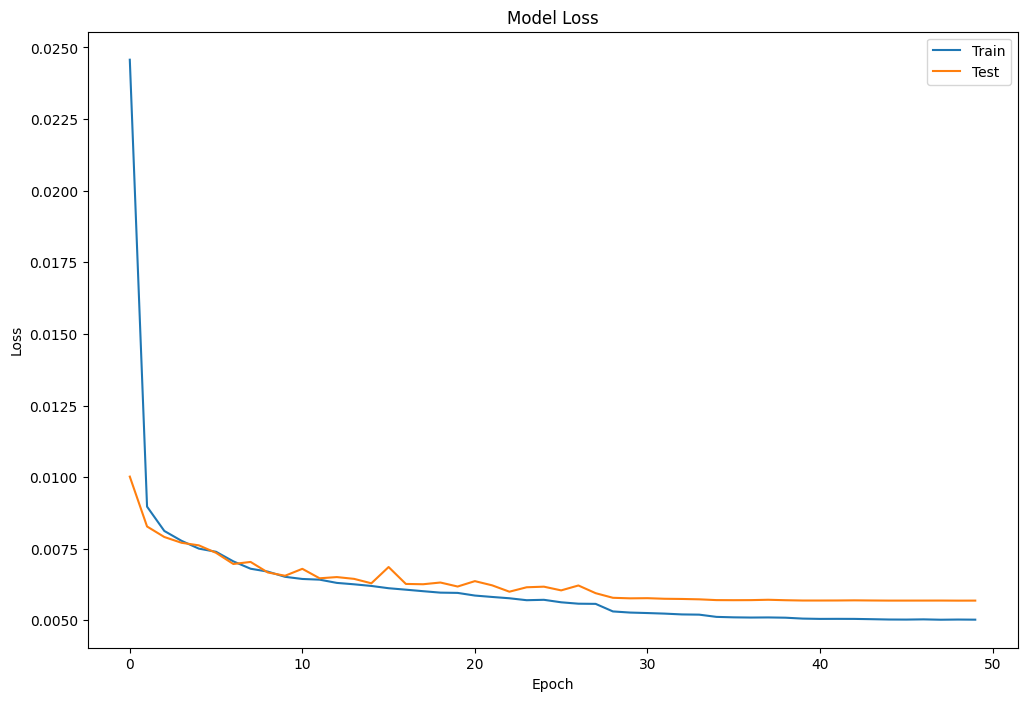

In [30]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Model Loss')
plt.savefig('Autoencoder-Model-Loss.png')
plt.show()

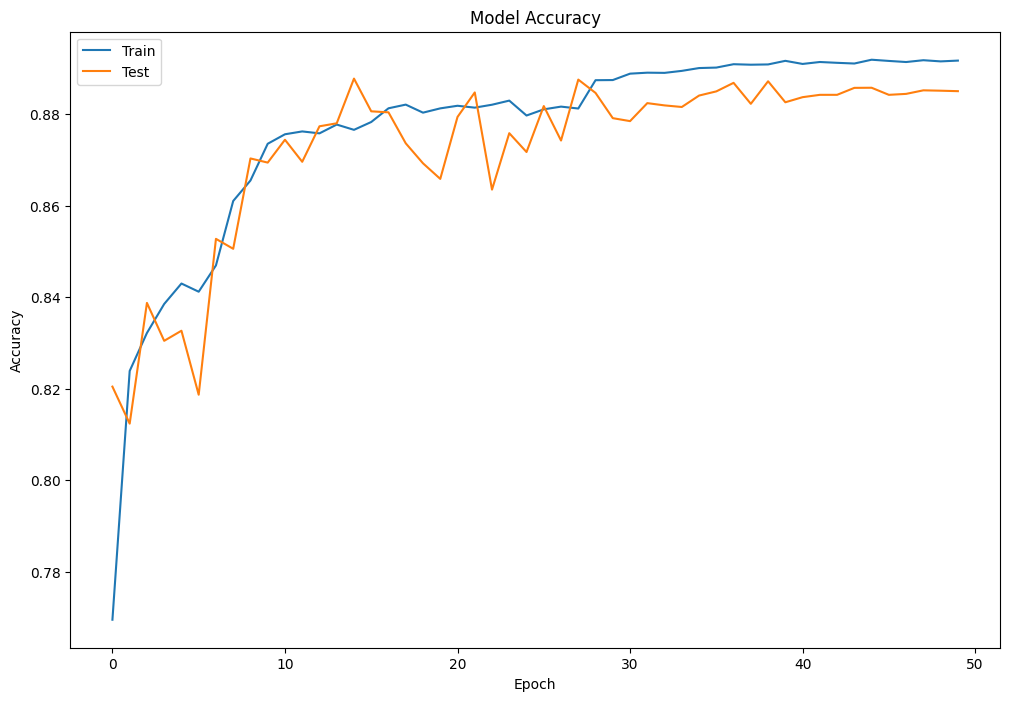

In [31]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.savefig('Autoencoder-Model-Accuracy.png')
plt.show()

In [32]:
from keras.models import model_from_json

autoencoder_json = autoencoder.to_json()
with open("autoencoder_model_architecture.json", "w") as json_file:
    json_file.write(autoencoder_json)

autoencoder.save_weights("autoencoder_model.weights.h5")

In [39]:
tf.saved_model.save(autoencoder, 'autoencoder')

In [40]:
autoencoder.save('autoencoder_model.keras')

## De-Blurred Faces


			Input						Ground Truth						Predicted Value


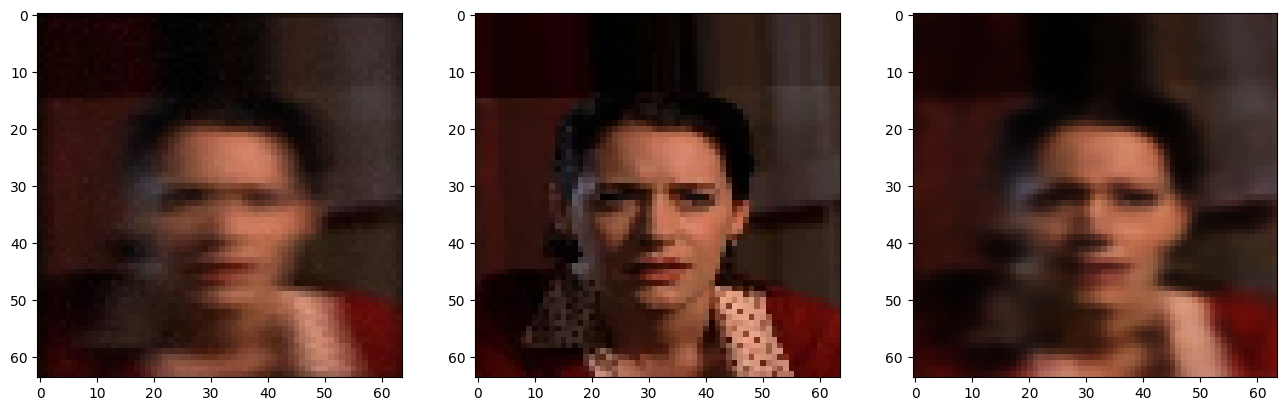

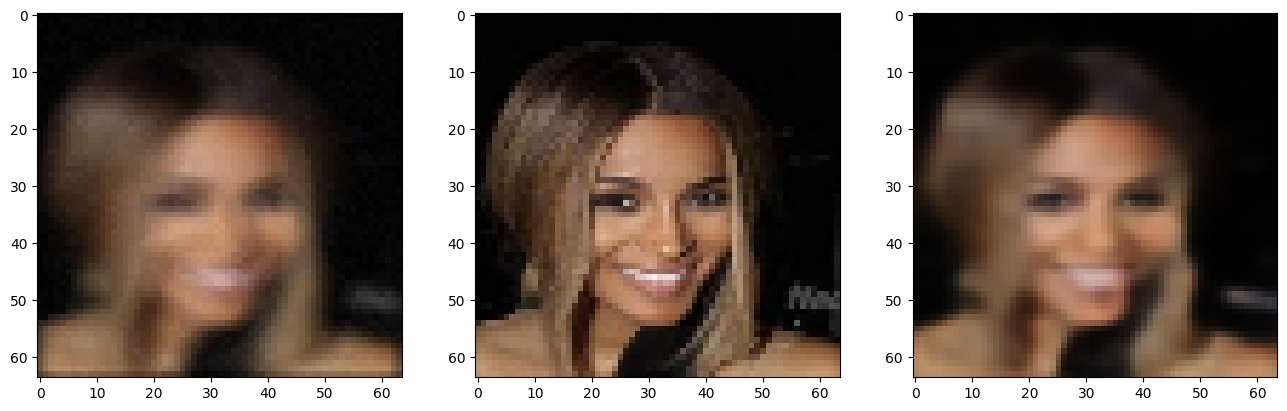

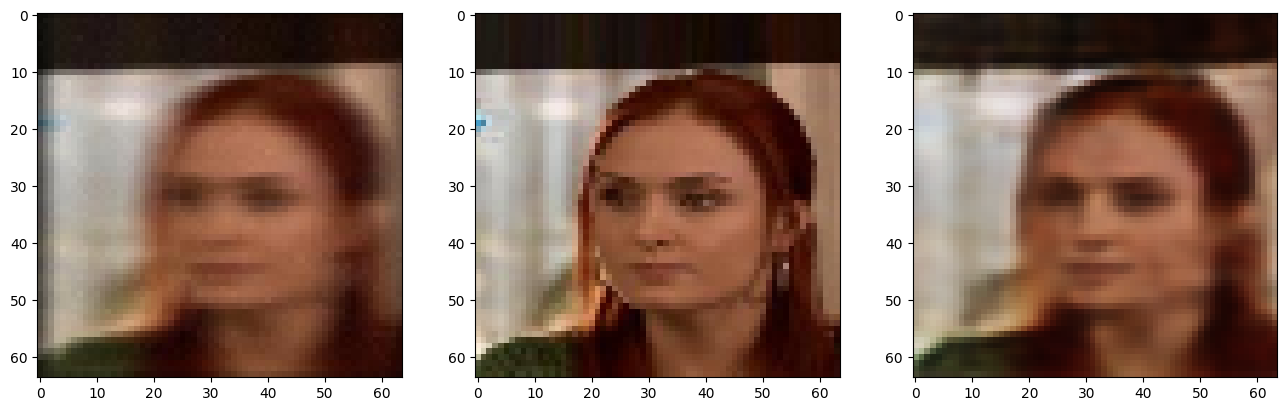

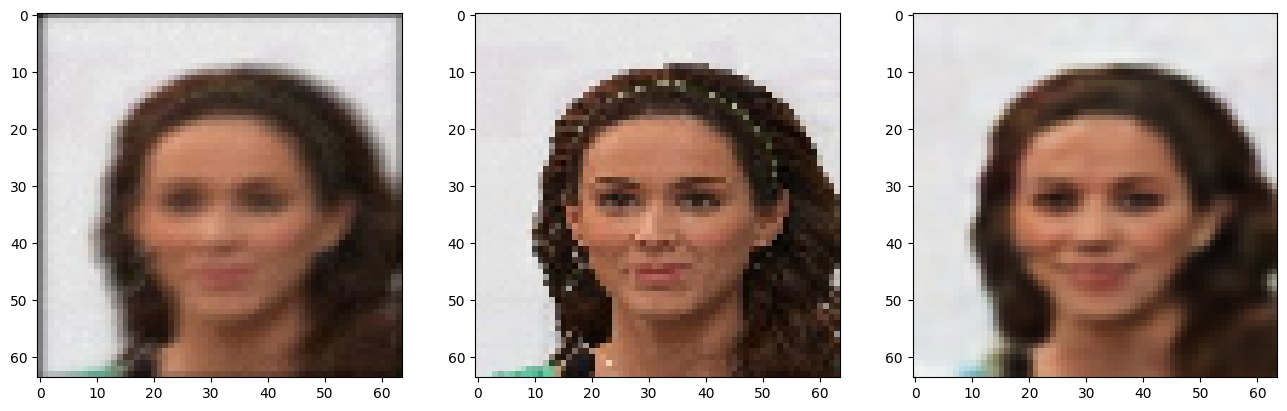

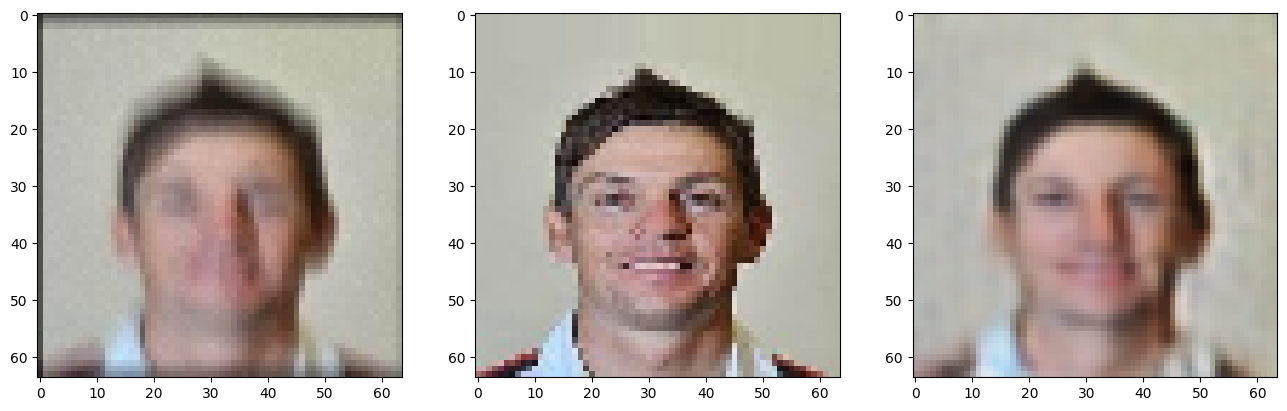

In [45]:
print("\n\t\t\tInput\t\t\t\t\t\tGround Truth\t\t\t\t\t\tPredicted Value")

for i in range(5):
    index = random.randint(0, len(test_blurred_frames)-1)

    x = test_blurred_frames[index]
    y = test_sharp_frames[index]

    x_inp = x.reshape(1,64,64,3)
    result = autoencoder.predict(x_inp, verbose = 0)
    result = result.reshape(64,64,3)

    fig = plt.figure(figsize=(16,13))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    
    fig.savefig('autoencoder_result.png')
    plt.imshow(result)

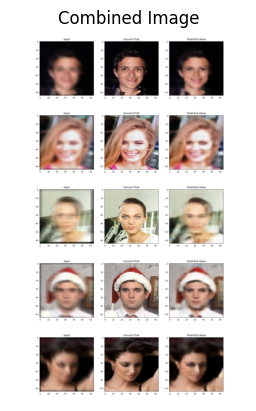

Combined image saved successfully: autoencoder_result.png


In [52]:
subplot_paths = []

for i in range(5):
    index = random.randint(0, len(test_blurred_frames) - 1)

    x = test_blurred_frames[index]
    y = test_sharp_frames[index]

    x_inp = x.reshape(1, 64, 64, 3)
    result = autoencoder.predict(x_inp, verbose=0)
    result = result.reshape(64, 64, 3)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    axes[0].imshow(x)
    axes[0].set_title("Input")

    axes[1].imshow(y)
    axes[1].set_title("Ground Truth")

    axes[2].imshow(result)
    axes[2].set_title("Predicted Value")

    subplot_path = f"subplot_{i + 1}.png"
    plt.savefig(subplot_path)
    plt.close(fig)

    subplot_paths.append(subplot_path)

combined_image = np.concatenate([plt.imread(path) for path in subplot_paths], axis=0)

output_image_path = "autoencoder_result.png"
plt.imsave(output_image_path, combined_image)

plt.imshow(combined_image)
plt.axis('off')
plt.title("Combined Image")
plt.show()

print("Combined image saved successfully:", output_image_path)

## Model Completed!